In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle


In [3]:
! cp kaggle.json~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [00:28<00:00, 145MB/s]
100% 4.00G/4.00G [00:28<00:00, 153MB/s]


In [7]:
! unzip state-farm-distracted-driver-detection

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

In [10]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras 

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16


dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [11]:
# Groupby subjects
by_drivers = dataset.groupby('subject') 
# Groupby unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id
print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(dataset.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


In [12]:
NUMBER_CLASSES = 10 # 10 classes

In [17]:
# Read with opencv
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    """
    Function that return an opencv image from the path and the right number of dimension
    """
    if color_type == 1: # Loading as Grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: # Loading as color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

# Loading Training dataset
def load_train(img_rows, img_cols, color_type=3):
    """
    Return train images and train labels from the original path
    """
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('imgs/train/c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    """
    Load + categorical + split
    """
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10) #categorical train label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split into train and test
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [18]:
img_rows = 64 # dimension of images
img_cols = 64
color_type = 1 # grey
nb_test_samples = 200

# loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:03<00:27,  3.10s/it]

Loading directory c1


 20%|██        | 2/10 [00:06<00:27,  3.48s/it]

Loading directory c2


 30%|███       | 3/10 [00:09<00:22,  3.19s/it]

Loading directory c3


 40%|████      | 4/10 [00:12<00:18,  3.08s/it]

Loading directory c4


 50%|█████     | 5/10 [00:15<00:15,  3.01s/it]

Loading directory c5


 60%|██████    | 6/10 [00:18<00:11,  2.96s/it]

Loading directory c6


 70%|███████   | 7/10 [00:21<00:08,  2.93s/it]

Loading directory c7


 80%|████████  | 8/10 [00:23<00:05,  2.80s/it]

Loading directory c8


 90%|█████████ | 9/10 [00:26<00:02,  2.68s/it]

Loading directory c9


  0%|          | 200/79726 [00:00<01:57, 676.88it/s]


In [20]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob("imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('imgs/test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


In [21]:
import plotly.express as px

px.histogram(dataset, x="classname", color="classname", title="Number of images by categories ")

In [22]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

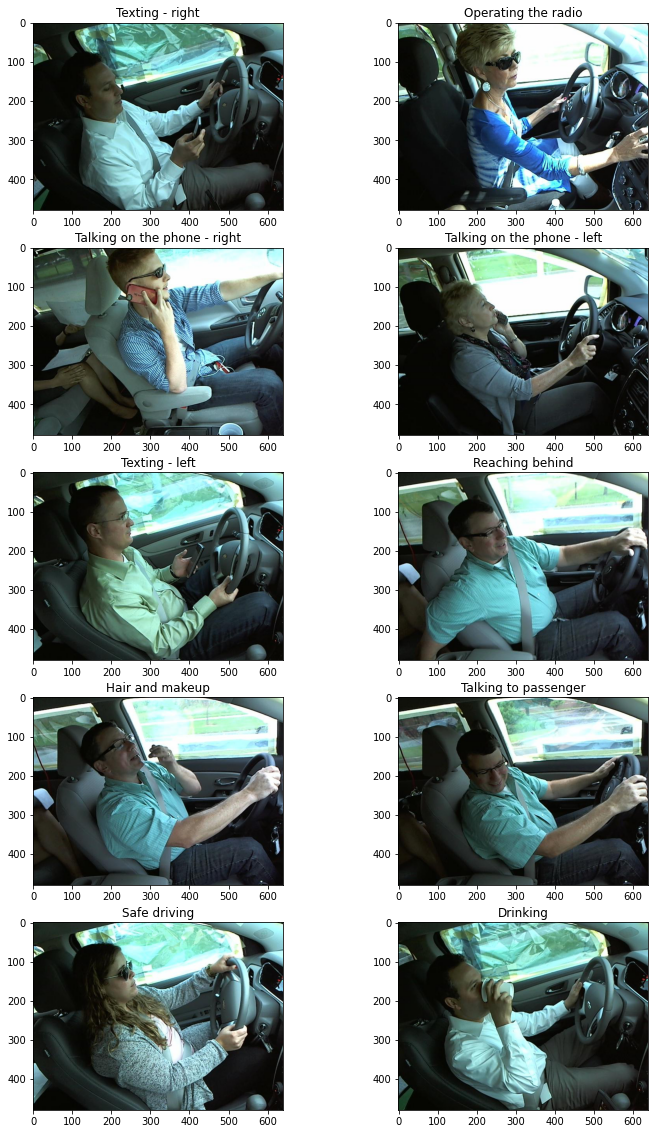

In [24]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = 'imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])


In [25]:
def create_submission(predictions, test_id, info):
    """
    Submission function for participating to the competition
    """
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

In [26]:
# Number of batch size and epochs
batch_size = 40 #40
nb_epoch = 6 #10

In [27]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#callbacks = [checkpointer, es]

In [28]:
def create_model():
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [29]:
model = create_model()

# More details about the layers
model.summary()

# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                        

In [30]:
history = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

#model.load_weights('saved_models/weights_best_vanilla.hdf5')
print('History of the training',history.history)

Epoch 1/6
449/449 [==============================] - 369s 816ms/step - loss: 1.2503 - accuracy: 0.5933 - val_loss: 0.6963 - val_accuracy: 0.8116
Epoch 2/6
449/449 [==============================] - 357s 794ms/step - loss: 0.3380 - accuracy: 0.8923 - val_loss: 0.0942 - val_accuracy: 0.9717
Epoch 3/6
449/449 [==============================] - 355s 792ms/step - loss: 0.2047 - accuracy: 0.9377 - val_loss: 0.3190 - val_accuracy: 0.9193
Epoch 4/6
449/449 [==============================] - 360s 801ms/step - loss: 0.1659 - accuracy: 0.9511 - val_loss: 0.1534 - val_accuracy: 0.9652
Epoch 5/6
449/449 [==============================] - 359s 800ms/step - loss: 0.1341 - accuracy: 0.9597 - val_loss: 0.0717 - val_accuracy: 0.9862
Epoch 6/6
449/449 [==============================] - 358s 798ms/step - loss: 0.1139 - accuracy: 0.9662 - val_loss: 0.0502 - val_accuracy: 0.9900
History of the training {'loss': [1.2503288984298706, 0.3380138874053955, 0.2047145664691925, 0.16586151719093323, 0.1341462433338

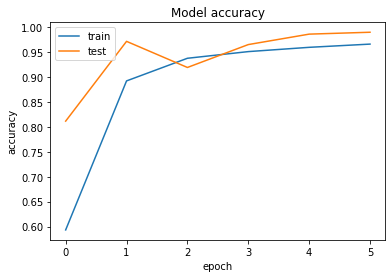

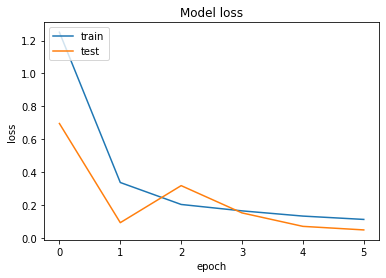

In [31]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_train_history(history)

In [32]:
def plot_test_class(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [33]:
score1 = model.evaluate(x_test, y_test, verbose=1)

141/141 [==============================] - 23s 163ms/step - loss: 0.0502 - accuracy: 0.9900


In [34]:
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

Loss:  0.05017572641372681
Accuracy:  98.99665713310242  %


1/1 [==============================] - 1s 598ms/step
Y prediction: [[2.8699981e-12 1.0573417e-18 2.8008501e-14 3.2636900e-13 1.8938058e-14
  1.0000000e+00 1.6959007e-14 1.1909654e-12 2.9985558e-12 4.4759365e-09]]
Predicted: Operating the radio


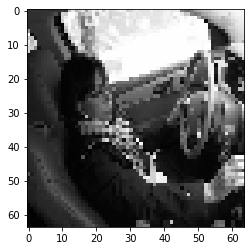

1/1 [==============================] - 0s 37ms/step
Y prediction: [[1.7379967e-10 9.6996233e-15 4.6399357e-11 3.6092974e-13 1.3424057e-09
  1.0000000e+00 6.0617750e-10 4.4459323e-14 1.1861589e-09 3.2439257e-08]]
Predicted: Operating the radio


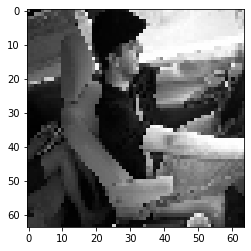

1/1 [==============================] - 0s 56ms/step
Y prediction: [[1.1110513e-03 3.5590175e-04 2.3879657e-06 7.0442138e-03 1.0622906e-07
  8.4430076e-13 6.5447075e-08 6.3834436e-06 4.8947319e-01 5.0200677e-01]]
Predicted: Talking to passenger


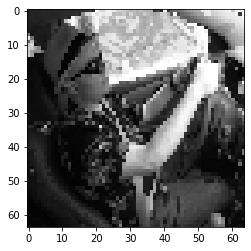

1/1 [==============================] - 0s 41ms/step
Y prediction: [[6.6022818e-05 6.6269793e-05 1.3584198e-02 1.4650978e-09 4.1081067e-09
  8.6465435e-10 1.2708785e-05 4.1485760e-07 9.8618329e-01 8.7091052e-05]]
Predicted: Hair and makeup


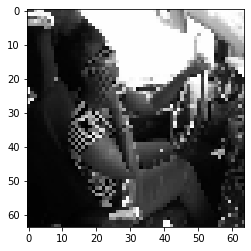

1/1 [==============================] - 0s 22ms/step
Y prediction: [[1.2211358e-04 4.0289212e-09 5.7127547e-10 2.1117970e-02 9.7872055e-01
  8.8819598e-07 5.9894196e-09 5.3459887e-10 3.1338997e-05 7.0121478e-06]]
Predicted: Talking on the phone - left


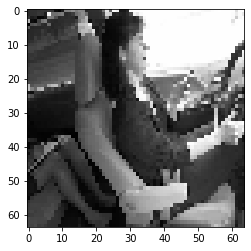

1/1 [==============================] - 0s 25ms/step
Y prediction: [[1.8685002e-10 1.7369944e-08 3.9992826e-17 1.0000000e+00 7.9482437e-10
  9.5378230e-13 9.3437112e-14 1.3303778e-12 3.7072732e-12 9.3836244e-11]]
Predicted: Texting - left


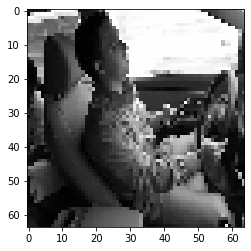

1/1 [==============================] - 0s 20ms/step
Y prediction: [[5.5247780e-05 8.5892476e-04 4.4053859e-06 3.8294920e-06 8.2448742e-07
  3.6174031e-05 7.7073812e-03 2.0712240e-04 1.9541153e-01 7.9571456e-01]]
Predicted: Talking to passenger


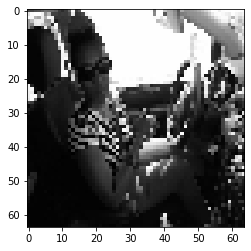

1/1 [==============================] - 0s 25ms/step
Y prediction: [[5.6046965e-03 2.9663432e-05 2.4608246e-07 2.0951641e-01 1.5100783e-04
  1.9010758e-05 3.4434143e-07 4.4106549e-04 6.0242629e-03 7.7821332e-01]]
Predicted: Talking to passenger


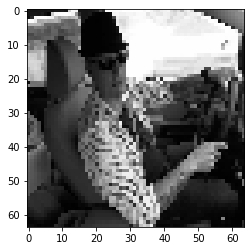

1/1 [==============================] - 0s 21ms/step
Y prediction: [[1.0293987e-11 5.9578475e-09 7.7960111e-05 8.4016573e-16 1.9821215e-08
  4.6142541e-11 9.9992001e-01 3.5433378e-13 2.0663017e-06 5.0767349e-11]]
Predicted: Drinking


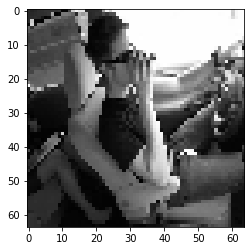

1/1 [==============================] - 0s 27ms/step
Y prediction: [[1.3066599e-13 1.3455973e-09 9.0835776e-12 2.4889036e-15 1.4438085e-12
  3.4455660e-13 9.5833768e-09 1.0000000e+00 1.5024034e-08 7.7364721e-12]]
Predicted: Reaching behind


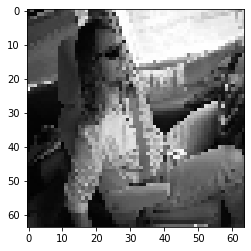

In [35]:
for i in range(10):
    plot_test_class(model, test_files, i)

In [36]:
# Using ImageDataGenerator from keras
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [37]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [39]:
#checkpoint = ModelCheckpoint('saved_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v2 = model.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = nb_epoch, 
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/6
448/448 [==============================] - 402s 896ms/step - loss: 0.3215 - accuracy: 0.9028 - val_loss: 0.0905 - val_accuracy: 0.9792
Epoch 2/6
448/448 [==============================] - 377s 841ms/step - loss: 0.3020 - accuracy: 0.9117 - val_loss: 0.0914 - val_accuracy: 0.9804
Epoch 3/6
448/448 [==============================] - 377s 842ms/step - loss: 0.2840 - accuracy: 0.9144 - val_loss: 0.0950 - val_accuracy: 0.9792
Epoch 4/6
448/448 [==============================] - 377s 841ms/step - loss: 0.2646 - accuracy: 0.9237 - val_loss: 0.0799 - val_accuracy: 0.9839
Epoch 5/6
448/448 [==============================] - 375s 838ms/step - loss: 0.2570 - accuracy: 0.9273 - val_loss: 0.0952 - val_accuracy: 0.9783
Epoch 6/6
448/448 [==============================] - 375s 837ms/step - loss: 0.2445 - accuracy: 0.9319 - val_loss: 0.0607 - val_accuracy: 0.9859


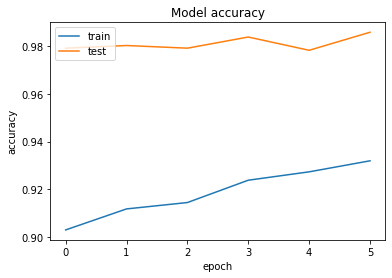

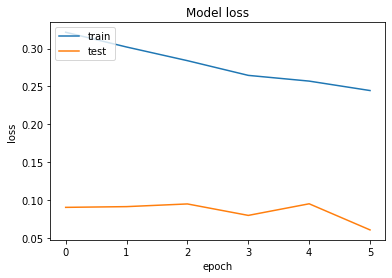

In [40]:
#model2.load_weights('saved_models/weights_best_va nilla.hdf5')
plot_train_history(history_v2)

In [41]:
# Evaluate and compare the performance of the new model
score2 = model.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Loss for model 1",score1[0])
print("Loss for model 2 (data augmentation):", score2[0])

print("Test accuracy for model 1",score1[1])
print("Test accuracy for model 2 (data augmentation):", score2[1])

Loss for model 1 0.05017572641372681
Loss for model 2 (data augmentation): 0.06110767647624016
Test accuracy for model 1 0.9899665713310242
Test accuracy for model 2 (data augmentation): 0.9857142567634583


In [42]:
def vgg_std16_model(img_rows, img_cols, color_type=3):
    """
    Architecture and adaptation of the VGG16 for our project
    """
    nb_classes = 10
    # Remove fully connected layer and replace
    vgg16_model = VGG16(weights="imagenet", include_top=False)
    for layer in vgg16_model.layers:
        layer.trainable = False
    
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x) # add dense layer with 10 neurons and activation softmax
    model = Model(vgg16_model.input,predictions)
    return model

In [43]:
# Load the VGG16 network
print("Loading network...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)
model_vgg16.summary()
model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                           

In [45]:
training_generator = train_datagen.flow_from_directory('imgs/train', 
                                                 target_size = (img_rows, img_cols), 
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")

validation_generator = test_datagen.flow_from_directory('imgs/test', 
                                                   target_size = (img_rows, img_cols), 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 17943
nb_validation_samples = 4481


Found 17943 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


In [46]:
epoch=6

In [47]:
# Training the new Model
#checkpoint = ModelCheckpoint('saved_models/weights_best_vgg16.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_vgg16.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = epoch, 
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/6
448/448 [==============================] - 576s 1s/step - loss: 1.6658 - accuracy: 0.4093
Epoch 2/6
448/448 [==============================] - 568s 1s/step - loss: 1.1916 - accuracy: 0.5853
Epoch 3/6
448/448 [==============================] - 569s 1s/step - loss: 0.9748 - accuracy: 0.6661
Epoch 4/6
448/448 [==============================] - 568s 1s/step - loss: 0.8352 - accuracy: 0.7147
Epoch 5/6
448/448 [==============================] - 569s 1s/step - loss: 0.7381 - accuracy: 0.7469
Epoch 6/6
448/448 [==============================] - 568s 1s/step - loss: 0.6661 - accuracy: 0.7746


KeyError: ignored

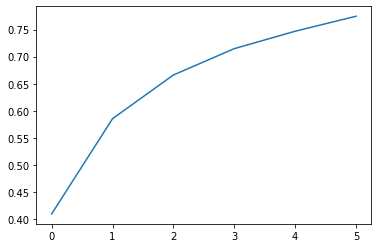

In [48]:
plot_train_history(history_v3)